# Gerando Word Embeddings Estáticas para o córpus de texto dos projetos da Embrapa

## Leitura e processamento do corpus

Integração do Colab com o Drive:

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/PIE-Embrapa/

/content/drive/MyDrive/Colab Notebooks/PIE-Embrapa


Importando bibliotecas:

In [1]:
import os
import gensim
import time
from nltk import sent_tokenize

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\m-hc8\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m-hc8\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Recuperando os nomes dos arquivos que contém os textos anotados dos projetos (termos do domínio são destacados com <>, sendo que, se o termo é composto de mais de uma palavra, as mesmas são unidas com _ ):

In [3]:
print('Digite o path para os textos:')
path_projetos = input()
try:
    projetos = os.listdir(path_projetos)
except:
    print('Path inexistente - não foi possível localizar os textos')
    raise
print('Número de arquivos encontrados:', len(projetos))

Digite o path para os textos:
Número de arquivos encontrados: 7007


Lendo e tokenizando todas as sentenças do *corpus*:

In [126]:
# Lista de armazenamento de sentenças
sentencas  = []
sentencas_projeto_inteiro = []
arquivos_resumos = dict()
arquivos_sentencas = dict()
j = 0
# Para cada arquivo de texto
for i, filename in enumerate(projetos):
  arquivos_resumos[i] = filename
  inicio = len(sentencas)
  fim = inicio+1
  f = open(os.path.join(path_projetos,filename), encoding='utf8')
  projeto = f.read()
  # sent_tokenize() separa as frases do texto
  frases = sent_tokenize(projeto)
  # Para cada frase
  for frase in frases:
    fim = fim + 1
    # word_tokenize() recupera os tokens em uma frase
    tokens = nltk.word_tokenize(frase)  
    # Para cada token, o mesmo é armazenado em sua forma minúscula caso não seja stopword
    # e seja alfanumérico. Ademais, se há "_" no token significa que este é um n-grama do
    # domínio e, portanto, é também armazenado
    processada = [w.lower() for w in tokens if not w.lower() in stopwords and w.isalnum() or '_' in w]
    # Por fim, a sentença processada é adicionada à lista de sentenças
    if processada:
      sentencas.append(processada)
      arquivos_sentencas[j] = filename
      j = j + 1
  sentencas_projeto_inteiro.append(sentencas[inicio:fim])  
print('No total há', len(sentencas), 'sentenças no córpus ' + path_projetos + '.')

No total há 86997 sentenças no córpus cp-resumos-corrigido-final.


In [5]:
resumos_inteiros = [sum(inner_list, []) for inner_list in sentencas_projeto_inteiro]

Exemplo de sentença pré-processada e tokenizada:

In [6]:
print(sentencas[0])

['brasil', 'segundo', 'censo_agropecuário_de_2006', 'total', 'áreas', 'ocupadas', 'pastagens', 'cultivadas', 'nativas', 'corresponde', 'cerca', '106', '46', 'milhões', 'hectares', 'respectivamente', 'comportando', 'rebanho', 'bovino', '160', '200', 'milhões', 'cabeças', 'além', 'ovinos', 'caprinos', 'equinos', 'bubalinos']


Podemos contar quantos *tokens* e *types* há nessas sentenças:

In [7]:
from nltk.lm.preprocessing import flatten
tokens = list(flatten(sentencas))
print('Número de tokens:', len(list(flatten(sentencas))))
print('Número de types :', len(list(set(tokens))))

Número de tokens: 1524853
Número de types : 58026


## Gerando WEs estáticos

### Word2Vec

In [7]:
from gensim.models import Word2Vec

start_time = time.time()

w2v_embeddings = Word2Vec(sentencas, 
                          min_count=3,     # Ignora palavras que ocorrem menos de 3 vezes
                          vector_size=300, # Dimensão das embeddings
                          workers=8,       # Número de processadores (paralelização)
                          window=5,        # Tamanho da janela de contexto, em palavras, usada durante o treinamento
                          epochs=30)       # Número de épocas de treinamento
print('Tempo para geração das embeddings com Word2Vec:', round((time.time() - start_time),2), 'segundos')

Tempo para geração das embeddings com Word2Vec: 14.49 segundos


In [8]:
print('Dimensão do vocabulário obtido:', len(w2v_embeddings.wv))

Dimensão do vocabulário obtido: 26179


Palavras para as quais foram geradas embeddings:

In [9]:
print(w2v_embeddings.wv.index_to_key)

['projeto', 'produção', 'uso', 'desenvolvimento', 'brasil', 'embrapa', 'sistemas', 'além', 'espécies', 'forma', 'sobre', 'diferentes', 'manejo', 'qualidade', 'tecnologias', 'maior', 'produtos', 'áreas', 'sendo', 'objetivo', 'resultados', 'proposta', 'região', 'cultivares', 'plantas', 'ações', 'informações', 'grande', 'assim', 'produtividade', 'meio', 'pesquisa', 'solo', 'cultura', 'produtores', 'processo', 'potencial', 'controle', 'atividades', 'ainda', 'sistema', 'avaliação', 'condições', 'estudos', 'principais', 'visando', 'área', 'aumento', 'regiões', 'cultivo', 'novas', 'bem', 'base', 'dados', 'partir', 'cada', 'soja', 'resistência', 'conhecimento', 'presente', 'deste', 'pode', 'outros', 'anos', 'quanto', 'principalmente', 'características', 'avaliar', 'outras', 'através', 'utilização', 'país', 'mercado', 'desta', 'neste', 'culturas', 'ação', 'processos', 'redução', 'atividade', 'campo', 'podem', 'importância', '1', 'técnicas', 'doenças', 'animais', 'eficiência', 'agricultores', '2

Salvando o modelo:

In [28]:
print('Digite o nome do modelo:')
w2v_model_name = input()
w2v_embeddings.save(w2v_model_name + '.model')

Digite o nome do modelo:


In [30]:
w2v_embeddings.wv.save_word2vec_format('w2v_embeddings.bin', binary=True)

Carregando um modelo já treinado:

In [9]:
from gensim.models import Word2Vec
print('Digite o nome do modelo:')
w2v_model_name = input()
try:
    w2v_embeddings = Word2Vec.load(w2v_model_name + '.model')
except:
    print('Modelo inexistente - não foi possível localizar o modelo')
    raise


Digite o nome do modelo:


Definindo funções auxiliares para visualização gráfica das distânicas entre palavras em 2 dimensões:

In [15]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('classic')
from sklearn.decomposition import PCA

In [16]:
def display_pca_scatterplot(model, words):
    word_vectors = np.array([model.wv[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

Visualizando as 10 palavras mais similares à `pasto` segundo o Word2Vec e sua representação vetorial:

In [10]:
word = 'pasto'
most_similar_words = w2v_embeddings.wv.most_similar(word)
most_similar_words

[('confinamento', 0.5995891690254211),
 ('pastagem', 0.5891143083572388),
 ('cria', 0.5059669017791748),
 ('forrageira', 0.489240437746048),
 ('sombra', 0.48813992738723755),
 ('vacas', 0.4856666028499603),
 ('novilhas', 0.4816848635673523),
 ('silagem', 0.4811980128288269),
 ('pastos', 0.48112887144088745),
 ('alimentação_de_bovinos', 0.4790978729724884)]

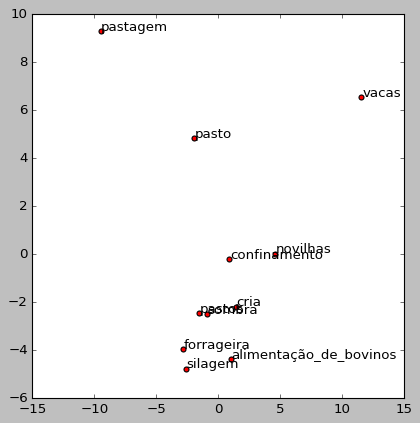

In [61]:
words = [word]
for i in range(10):
  words.append(most_similar_words[i][0])
display_pca_scatterplot(w2v_embeddings, words)

In [62]:
w2v_embeddings.wv[word]

array([ 0.02473655, -1.2024639 ,  0.4208575 , -0.7549939 , -0.16856115,
        1.7787838 ,  0.8844358 ,  1.162502  ,  0.74495673, -0.48746523,
        1.0270196 , -0.44964266, -0.47374088, -0.8264716 ,  0.8991482 ,
       -0.01191696,  1.2288476 ,  1.3099965 ,  0.37158874,  1.2695287 ,
        1.3919197 ,  0.02121592, -0.17618799, -1.4726853 , -1.2874401 ,
        0.40841204,  1.0825108 , -1.1007049 ,  1.2873847 ,  0.80368346,
        0.9584601 , -1.2271513 , -2.657115  , -0.75586635,  0.22117873,
        0.9819741 ,  1.296259  , -1.269019  ,  0.59070706,  0.21989298,
        0.21898225,  0.19129346,  0.7143127 ,  0.36201453,  1.5433182 ,
        0.8077969 , -0.66059273,  1.1243716 ,  0.14970006, -0.10658719,
        1.6932193 ,  1.1381949 , -0.32598338, -0.8843765 , -0.6254941 ,
        0.90058583, -1.217982  ,  0.4960394 , -0.03394209, -0.41085556,
        0.6200619 , -0.09984352,  0.6122013 ,  0.72778064,  1.0379854 ,
       -1.1399075 , -0.7978234 , -0.06257178,  0.24315748,  0.16

### Sent2Vec

In [11]:
from sent2vec.vectorizer import Vectorizer

c:\Users\m-hc8\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
sentencas_unidas = [' '.join(frase) for frase in sentencas]

In [111]:
vectorizer = Vectorizer(pretrained_weights= "w2v_embeddings.bin", ensemble_method='average')
vectorizer.run(sentencas_unidas, remove_stop_words = [], add_stop_words = [])
vectors_w2v = vectorizer.vectors

Initializing word2vec with vector path w2v_embeddings.bin


KeyError: "Key 'pastagen' not present"

### Average Feature Vector

In [112]:
def avg_feature_vector(sentence, model, num_features, index2word_set):
    #Inicializamos um vetor com zeros
    feature_vec = np.zeros((num_features, ), dtype='float32')
    #Divindo a sentença em palavras
    words = sentence.split()

    n_words = 0
    for word in words:
        #Se a palavra estiver no vocabulário
        if word in index2word_set:
            n_words += 1
            #Somamos o vetor da palavra ao vetor da sentença
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        #Dividimos o vetor da sentença pela quantidade de palavras que ele possui
        feature_vec = np.divide(feature_vec, n_words)
    else:
        return None
    
    #Retornamos o vetor da sentença
    return feature_vec

In [113]:
vectors_w2v = [
    avg_feature_vector(i, w2v_embeddings.wv, 300, w2v_embeddings.wv.index_to_key)
    for i in sentencas_unidas
]

In [114]:
from scipy import spatial
import sys

# Definindo 'na mão' uma função que retorna a primeira embedding 
# encontrada mais similar pela distância cosseno
def most_similar(target_idx, embeddings):
    menor_dist = sys.maxsize
    menor_idx = -1
    for i in [x for x in range(len(embeddings)) if x != target_idx]:
        try:
            cos_dist = spatial.distance.cosine(embeddings[target_idx], embeddings[i])
        except:
            cos_dist = sys.maxsize
        if cos_dist < menor_dist:
            menor_dist = cos_dist
            menor_idx = i
    return menor_idx, menor_dist

In [115]:
most_similar(0, vectors_w2v)

(1767, 0)

In [116]:
print(sentencas_unidas[0])
print(sentencas_unidas[1767])

brasil segundo censo_agropecuário_de_2006 total áreas ocupadas pastagens cultivadas nativas corresponde cerca 106 46 milhões hectares respectivamente comportando rebanho bovino 160 200 milhões cabeças além ovinos caprinos equinos bubalinos
brasil segundo censo_agropecuário_de_2006 total áreas ocupadas pastagens cultivadas nativas corresponde cerca 106 46 milhões hectares respectivamente comportando rebanho bovino 160 200 milhões cabeças além ovinos caprinos equinos bubalinos


In [117]:
most_similar(7582, vectors_w2v)

(3933, 0.298298716545105)

In [118]:
print(sentencas_unidas[7582])
print(sentencas_unidas[3933])

materiais serem avaliados constam introduções germoplasma coffea arabica coffea canephora instituições_de_pesquisa brasileiras internacionais
bancos_de_germoplasma café existentes brasil mantém cerca 20 espécies coffea descritas literatura além vasta coleção cultivares híbridos interespecíficos populações segregantes c arabica clones c canephora


### Doc2Vec

#### Nos resumos inteiros (cada resumo é um documento)

In [62]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(resumos_inteiros)]
d2v_model_inteiros = Doc2Vec(documents, vector_size=300, window=5, min_count=3, workers=8)

In [133]:
def doc2vec_most_similar(modelo, embedding, documentos, frase_original):
    print("Documento original:", " ".join(frase_original), "\n")
    for tupla in modelo.most_similar(embedding):
        print("Documento encontrado:", " ".join(documentos[tupla[0]]))
        print("Idx:", tupla[0])
        print("Distância:", 1-tupla[1], "\n")

In [134]:
doc2vec_most_similar(d2v_model_inteiros.dv, d2v_model_inteiros.dv[0], resumos_inteiros, resumos_inteiros[0])

Documento original: brasil segundo censo_agropecuário_de_2006 total áreas ocupadas pastagens cultivadas nativas corresponde cerca 106 46 milhões hectares respectivamente comportando rebanho bovino 160 200 milhões cabeças além ovinos caprinos equinos bubalinos acordo ipcc quarto emissões nacionais gases efeito_estufa gee precisamente 22 6 provém atividades agropecuárias sendo 93 ch4 emitido fonte fermentação entérica apesar valores citados agropecuária bem praticada grande potencial reduzir emissões gee desde determinadas estratégias manejo executadas intuito inserido mp1 dinâmica gases efeito_estufa sistemas produção agropecuária brasileira projeto componente objetivo aplicar geotecnologias entendimento relações causa efeito atividades agropecuárias processos emissões gases efeito_estufa gerando subsídios decisões manejos sustentáveis agronômica ambientalmente desenvolvimento projeto ocorrerá execução simultânea cinco planos ação segue 1 gestão projeto 2 atualização mapa pastagens cult

In [79]:
most_similar(0, d2v_model_inteiros.dv)

(152, 0.02036982774734497)

In [80]:
print(resumos_inteiros[0])
print(resumos_inteiros[152])

['brasil', 'segundo', 'censo_agropecuário_de_2006', 'total', 'áreas', 'ocupadas', 'pastagens', 'cultivadas', 'nativas', 'corresponde', 'cerca', '106', '46', 'milhões', 'hectares', 'respectivamente', 'comportando', 'rebanho', 'bovino', '160', '200', 'milhões', 'cabeças', 'além', 'ovinos', 'caprinos', 'equinos', 'bubalinos', 'acordo', 'ipcc', 'quarto', 'emissões', 'nacionais', 'gases', 'efeito_estufa', 'gee', 'precisamente', '22', '6', 'provém', 'atividades', 'agropecuárias', 'sendo', '93', 'ch4', 'emitido', 'fonte', 'fermentação', 'entérica', 'apesar', 'valores', 'citados', 'agropecuária', 'bem', 'praticada', 'grande', 'potencial', 'reduzir', 'emissões', 'gee', 'desde', 'determinadas', 'estratégias', 'manejo', 'executadas', 'intuito', 'inserido', 'mp1', 'dinâmica', 'gases', 'efeito_estufa', 'sistemas', 'produção', 'agropecuária', 'brasileira', 'projeto', 'componente', 'objetivo', 'aplicar', 'geotecnologias', 'entendimento', 'relações', 'causa', 'efeito', 'atividades', 'agropecuárias', '

In [81]:
arquivos_resumos[0]

'0000000000000-resumoprojeto_anotado-corrigido.txt'

In [82]:
arquivos_resumos[152]

'0110060011000-resumoprojeto_anotado-corrigido.txt'

In [83]:
arquivos_resumos[6662]

'38239-resumoprojeto_anotado-corrigido.txt'

In [84]:
most_similar(5005, d2v_model_inteiros.dv)

(3079, 0.23136192560195923)

In [85]:
print(resumos_inteiros[5005])
print(resumos_inteiros[3079])

['segundo', 'usda', '2018', 'carne_suína', 'respondeu', 'cerca', '40', 'consumo', 'humano', 'per', 'capita', 'mundial', 'contra', '21', '4', 'carne', 'boi', '33', '3', 'frango', '5', '3', 'ovelha', 'durante', 'processo', 'finalização', 'engorda', 'ractopamina', 'suplementada', 'ração', 'desses', 'animais', 'suplemento_alimentar', 'animal', 'agonista', 'receptores', 'promove', 'redirecionamento', 'nutrientes', 'direcionados', 'camadas', 'adiposas', 'músculos', 'promovendo', 'aumento', 'cerca', '3kg', 'massa', 'magra', 'animal', 'melhorando', 'eficiência', 'alimentar', '10', 'uso', 'ractopamina', 'nesse', 'processo', 'tornou', 'controverso', 'autoridades', 'segurança_alimentar', 'mundial', 'causando', 'banimento', 'uso', '160', 'países', 'objetivo', 'ideal', 'produtores', 'carne', 'conseguir', 'eficientemente', 'maior', 'produção', 'menor', 'custo', 'causar', 'danos', 'saúde', 'humana', 'animais', 'fatos', 'molécula', 'alternativa', 'ractopamina', 'mesmas', 'propriedades', 'farmacológica

In [86]:
projeto = 'A soja é originária da Ásia, mais provavelmente do nordeste da China, onde surgiu como uma planta rasteira, muito distinta da soja comercial que cultivamos hoje. Sua evolução iniciou-se, aparentemente, a partir de plantas oriundas de cruzamentos naturais entre duas espécies de soja selvagem, cujo produto foi domesticado e melhorado por cientistas da antiga China.'
projeto_tok = []
frases = sent_tokenize(projeto)
for frase in frases:
    tokens = nltk.word_tokenize(frase)  
    processada = [w.lower() for w in tokens if not w.lower() in stopwords and w.isalnum() or '_' in w]
    if processada:
        projeto_tok.append(processada)

In [89]:
projeto_tok_embedding = d2v_model_inteiros.infer_vector(list(flatten(projeto_tok)))
projeto_tok_embedding

array([ 0.02213186, -0.06736158, -0.0108228 , -0.16581364,  0.22750676,
        0.00658551,  0.03138148, -0.01129502,  0.04007406, -0.02549456,
       -0.04929943, -0.03540648, -0.00714754,  0.00849135, -0.01261988,
       -0.03758027,  0.03768676, -0.08042585,  0.07806597,  0.01275841,
        0.05274182,  0.04893709, -0.1258573 , -0.04637889,  0.00333615,
        0.00331625, -0.06767727,  0.02127985,  0.11500368, -0.11164872,
        0.10220452,  0.01871157,  0.01467256, -0.04099011,  0.01621708,
       -0.05953953,  0.12257532, -0.12736008, -0.13246845,  0.02790496,
        0.14269887, -0.07953302, -0.01225481,  0.00290941, -0.01238464,
       -0.00420994, -0.07127786, -0.05857297, -0.11652537,  0.04876125,
        0.07617814, -0.03699498, -0.01080636, -0.00949576, -0.25727415,
       -0.02550835, -0.02610348,  0.08278383,  0.17341563,  0.06465789,
       -0.06502991,  0.10804017, -0.11079873,  0.13331077,  0.21392979,
        0.01412629,  0.10622039,  0.1496292 , -0.08149149,  0.08

In [138]:
doc2vec_most_similar(d2v_model_inteiros.dv, projeto_tok_embedding, resumos_inteiros, list(flatten(projeto_tok)))

Documento original: soja originária ásia provavelmente nordeste china onde surgiu planta rasteira distinta soja comercial cultivamos hoje evolução aparentemente partir plantas oriundas cruzamentos naturais duas espécies soja selvagem cujo produto domesticado melhorado cientistas antiga china 

Documento encontrado: mercado_internacional existe ampla oferta produtos base café incluindo bebidas geladas chocolates aromatizados café outros brasil consumo café praticamente restrito cafezinho café pingado leite tradicional café leite estudos recentes indicam consumo moderado café pode ter efeitos benéficos saúde humana coloca categoria produto funcional busca alimentos nutritivos saudáveis vem crescendo parcela significativa população alimentos base soja vêm sendo relacionados redução_de_risco várias doenças crônicas incluindo câncer_de_mama próstata osteoporose doenças coronarianas soja principais commodities agrícolas brasil entretanto alimento alto valor_nutricional funcional pouco utiliz

#### Nas sentenças (cada sentença é um documento)

In [123]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(sentencas)]
d2v_model_sentencas = Doc2Vec(documents, vector_size=300, window=5, min_count=3, workers=8)

In [135]:
doc2vec_most_similar(d2v_model_sentencas.dv, d2v_model_sentencas.dv[0], sentencas, sentencas[0])

Documento original: brasil segundo censo_agropecuário_de_2006 total áreas ocupadas pastagens cultivadas nativas corresponde cerca 106 46 milhões hectares respectivamente comportando rebanho bovino 160 200 milhões cabeças além ovinos caprinos equinos bubalinos 

Documento encontrado: brasil segundo censo_agropecuário_de_2006 total áreas ocupadas pastagens cultivadas nativas corresponde cerca 106 46 milhões hectares respectivamente comportando rebanho bovino 160 200 milhões cabeças além ovinos caprinos equinos bubalinos
Idx: 0
Distância: 0.0 

Documento encontrado: brasil segundo censo_agropecuário_de_2006 total áreas ocupadas pastagens cultivadas nativas corresponde cerca 106 46 milhões hectares respectivamente comportando rebanho bovino 160 200 milhões cabeças além ovinos caprinos equinos bubalinos
Idx: 1767
Distância: 0.02366185188293457 

Documento encontrado: brasil segundo censo_agropecuário_de_2006 total áreas viróides pastagens cultivadas nativas corresponde cerca 106 46 milhões 

In [139]:
arquivos_sentencas[2888]

'0115020030000-resumoprojeto_anotado-corrigido.txt'

In [140]:
arquivos_sentencas[85208]

'4115020030000-resumoprojeto_anotado-corrigido.txt'

In [136]:
doc2vec_most_similar(d2v_model_sentencas.dv, projeto_tok_embedding, sentencas, list(flatten(projeto_tok)))

Documento original: soja originária ásia provavelmente nordeste china onde surgiu planta rasteira distinta soja comercial cultivamos hoje evolução aparentemente partir plantas oriundas cruzamentos naturais duas espécies soja selvagem cujo produto domesticado melhorado cientistas antiga china 

Documento encontrado: palmeira africana elaeis guineensis eg responsável maior produção óleo mundo superando soja
Idx: 39833
Distância: 0.4664503335952759 

Documento encontrado: ocorre soja commoditie múltiplas aplicações portanto dependência preços_de_mercado biodiesel demandado poderá outras fontes gorduras exemplo gordura_animal
Idx: 21061
Distância: 0.47078925371170044 

Documento encontrado: complexo soja primeiro lugar ranking exportações agronegócio viróides
Idx: 73738
Distância: 0.4719443917274475 

Documento encontrado: soja preta histórico antigo uso medicinal medicina oriental apresenta diferencial soja amarela presença antocianinas compostos bioativos casca
Idx: 42579
Distância: 0.48

### ChromaDB

https://docs.trychroma.com/usage-guide

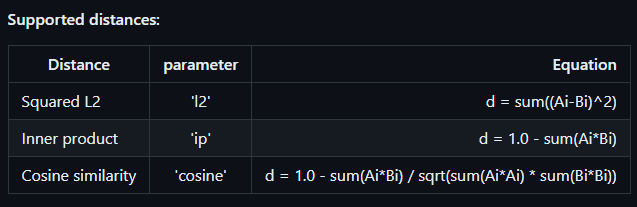

In [164]:
import chromadb
chroma_client = chromadb.Client()

In [165]:
w2v_collection = chroma_client.create_collection(name="w2v_collection")

In [166]:
w2v_collection.add(
    embeddings= d2v_model_sentencas.dv[d2v_model_sentencas.dv.index_to_key].tolist(),
    documents= sentencas_unidas,
    ids= [str(x) for x in d2v_model_sentencas.dv.index_to_key]
)

In [184]:
w2v_collection.get(
    ids=["0"]
)

{'ids': ['0'],
 'embeddings': None,
 'documents': ['brasil segundo censo_agropecuário_de_2006 total áreas ocupadas pastagens cultivadas nativas corresponde cerca 106 46 milhões hectares respectivamente comportando rebanho bovino 160 200 milhões cabeças além ovinos caprinos equinos bubalinos'],
 'metadatas': [None]}

In [175]:
query_result = w2v_collection.query(
        query_embeddings=[projeto_tok_embedding.tolist()],
        n_results=10,
    )

print(query_result)

{'ids': [['42579', '5861', '39833', '81419', '47222', '85595', '17135', '1539', '50659', '19880']], 'embeddings': None, 'documents': [['soja preta histórico antigo uso medicinal medicina oriental apresenta diferencial soja amarela presença antocianinas compostos bioativos casca', 'sendo assim razão outras oleaginosas disputam soja liderança nacional produção óleo_vegetal reside fato produz soja obter óleo', 'palmeira africana elaeis guineensis eg responsável maior produção óleo mundo superando soja', 'grande parte algodão semeado segunda safra região_centro-oeste onde localiza maior parte cerrado cultivado após soja superprecoce verão', 'força expansionista tamanha metade sul rs soja avançou 10 ano 2000 2009 atualmente ocupa área semelhante próprio arroz_irrigado ibge 2011', 'soja preta histórico antigo uso medicinal medicina oriental apresenta diferencial soja amarela presença antocianinas compostos bioativos casca', 'entanto segundo abiec associação_brasileira_das_indústrias_exportad

In [183]:
w2v_collection.upsert(
    ids = ["teste_adição"],
    embeddings=[projeto_tok_embedding.tolist()],
    documents=[' '.join([' '.join(frase) for frase in projeto_tok])]
)

### FastText

In [23]:
from gensim.models.fasttext import FastText

start_time = time.time()

ft_embeddings = FastText(sentencas, 
                         min_count=3,     # Ignora palavras que ocorrem menos de 3 vezes
                         vector_size=300, # Dimensão das embeddings
                         workers=8,       # Número de processadores (paralelização)
                         window=5,        # Tamanho da janela de contexto, em palavras, usada durante o treinamento
                         epochs=10)       # Número de épocas de treinamento
print('Tempo para geração das embeddings com FastText:', round((time.time() - start_time),2), 'segundos')

Tempo para geração das embeddings com FastText: 48.63 segundos


In [24]:
print('Dimensão do vocabulário obtido:', len(ft_embeddings.wv))

Dimensão do vocabulário obtido: 25548


Observa-se que a dimensão do vocabulário é a mesma obtida pelo Word2Vec dado que foram ignoradas palavras que ocorrem menos de 3 vezes no corpus em ambos os casos, sendo, assim, geradas embeddings para as demais palavras.

Salvando o modelo:

In [30]:
print('Digite o nome do modelo:')
ft_model_name = input()
ft_embeddings.save(ft_model_name + '.model')

Digite o nome do modelo:


In [29]:
'''
print('Digite o nome do modelo:')
ft_model_name = input()
try:
    ft_embeddings = Word2Vec.load(ft_model_name + '.model')
except:
    print('Modelo inexistente - não foi possível localizar o modelo')
    raise
'''

"\nprint('Digite o nome do modelo:')\nft_model_name = input()\ntry:\n    ft_embeddings = Word2Vec.load(ft_model_name + '.model')\nexcept:\n    print('Modelo inexistente - não foi possível localizar o modelo')\n    raise\n"

Realizando o mesmo processo feito anteriormente com a palavra `pasto`:

In [31]:
word = 'pasto'
most_similar_words = ft_embeddings.wv.most_similar(word)
most_similar_words

[('pastoril', 0.8785095810890198),
 ('arbopasto', 0.8682910203933716),
 ('sulpasto', 0.8629314303398132),
 ('mirapasto', 0.8520629405975342),
 ('pastejo', 0.8460795879364014),
 ('pastoris', 0.8313157558441162),
 ('pastoreio', 0.8238231539726257),
 ('pastagem', 0.7983449697494507),
 ('pasta', 0.7699096202850342),
 ('pasteurella', 0.763970136642456)]

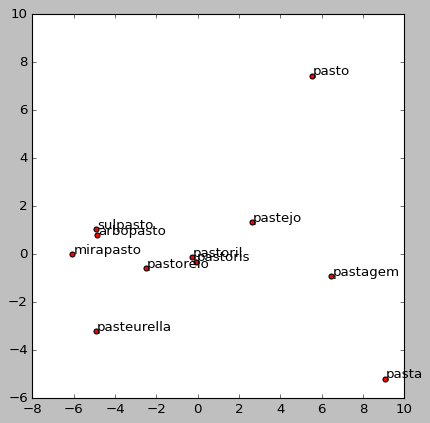

In [32]:
words = [word]
for i in range(10):
  words.append(most_similar_words[i][0])
display_pca_scatterplot(ft_embeddings, words)

In [33]:
ft_embeddings.wv[word]

array([ 6.38293773e-02,  4.26127613e-01, -1.87989581e+00,  1.90679240e+00,
        1.28066468e+00, -1.93259275e+00, -1.84222221e+00, -1.08194578e+00,
       -1.49851632e+00, -5.44470429e-01,  6.48498476e-01,  1.97046027e-01,
        1.97920501e+00, -1.17682338e+00,  2.60477990e-01, -1.02675366e+00,
       -8.23840499e-01, -1.14711717e-01, -1.63622618e+00,  1.79753602e+00,
        1.14144468e+00, -9.17284250e-01,  4.64686334e-01, -2.36183572e+00,
        4.85800534e-01, -6.33268476e-01, -5.03364682e-01, -1.57051194e+00,
        1.11084604e+00, -9.72963989e-01,  6.17089570e-01, -2.25477910e+00,
       -7.84807503e-01,  1.11595953e+00, -1.71543515e+00,  2.05178833e+00,
        7.81004727e-01,  2.29459047e-01,  6.39790237e-01,  1.65027475e+00,
        5.42992651e-01,  1.51585042e-01, -9.35527563e-01, -1.56309903e-01,
        2.05833817e+00, -4.97110158e-01,  1.69180167e+00, -1.18739641e+00,
        3.58762443e-01, -6.54549539e-01,  4.77684975e-01,  1.51670289e+00,
        2.08340383e+00,  

## Visualizando tópicos com o BERTopic

Instalando o <a href="https://github.com/MaartenGr/BERTopic">BERTopic</a>:

In [ ]:
!pip install bertopic

In [8]:
from tqdm import tqdm 
from bertopic import BERTopic

Armazenando cada projeto como um elemento da lista `texto`. Adicionalmente, os textos processados dos projetos são adicionados à lista `texto_processado`:

In [29]:
texto  = []
texto_processado = []
for filename in projetos:
  f = open(os.path.join(path_projetos,filename), encoding='utf8')  
  projeto = f.read() 
  texto.append(projeto)
  tokens = nltk.word_tokenize(projeto)
  processada = [w.lower() for w in tokens if not w.lower() in stopwords and w.isalnum() or '_' in w]
  texto_processado.append(' '.join(processada))

Gerando os tópicos e as probabilidades nos textos sem processamento:

In [34]:
topic_model = BERTopic(language='portuguese')
topics, probs = topic_model.fit_transform(texto)

Salvando o modelo:

In [42]:
print('Digite o nome do modelo:')
topic_model_name = input()
topic_model.save(topic_model_name)

Digite o nome do modelo:


In [44]:
'''
# carregando um modelo salvo
print('Digite o nome do modelo:')
topic_model_name = input()
try:
    topic_model = BERTopic.load(topic_model_name)
except:
    print('Modelo inexistente - não foi possível localizar o modelo')
    raise
'''

"\n# carregando um modelo salvo\nprint('Digite o nome do modelo:')\ntopic_model_name = input()\ntry:\n    topic_model = BERTopic.load(topic_model_name)\nexcept:\n    print('Modelo inexistente - não foi possível localizar o modelo')\n    raise\n"

Mostrando os 10 tópicos mais frequentes encontrados:

In [35]:
topic_model.get_topic_info().head(10)

,Topic,Count,Name
0,-1,2947,-1_de_da_para_em
1,0,404,0_embrapa_de_da_para
2,1,173,1_de_produção_em_no
3,2,169,2_café_cafeicultura_cafés_cafeeiro
4,3,98,3_de_para_sistemas_que
5,4,94,4_alimentos_consumo_produtos_de
6,5,92,5_microrganismos_bactérias_coleções_estirpes
7,6,78,6_amazônia_da_na_sistemas
8,7,73,7_semiárido_de_do_para
9,8,70,8_espécies_espécie_abelhas_de


Vale ressaltar que o tópico -1 se refere aos outliers e, portanto, deve ser ignorado.

Dessa forma, podemos visualizar melhor o tópico mais frequente encontrado, com suas palavras e o c-TF-IDF score de cada uma:

In [36]:
topic_model.get_topic(0)

[('embrapa', 0.014320862767885544),
 ('de', 0.008743759125566217),
 ('da', 0.008365544445740324),
 ('para', 0.007609600944938851),
 ('com', 0.007256545198749396),
 ('do', 0.006981618098069773),
 ('que', 0.006946168485870697),
 ('projeto', 0.006728348218616857),
 ('em', 0.006346502392308344),
 ('comunicação', 0.006329052437074888)]

Visualizando os tópicos de maneira similar ao <a href="https://github.com/cpsievert/LDAvis">LDAvis</a>:

In [37]:
topic_model.visualize_topics()

Podemos também visualizar os tópicos de maneira hierárquica graças ao uso do HDBSCAN:

In [38]:
topic_model.visualize_hierarchy(top_n_topics=50)

Visualizando alguns termos selecionados dos 5 tópicos mais recorrentes e seus c-TF-IDF scores:

In [39]:
topic_model.visualize_barchart(top_n_topics=5)

Montando uma matriz de similaridade entre os tópicos através da similaridade por cosseno baseada tanto nos c-TF-IDF scores quanto nas embeddings geradas:

In [40]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

Realizando os mesmos procedimentos, mas agora com os textos processados:

In [41]:
topic_model = BERTopic(language='portuguese')
topics, probs = topic_model.fit_transform(texto_processado)

In [43]:
topic_model.get_topic_info().head(10)

,Topic,Count,Name
0,-1,2479,-1_produção_projeto_embrapa_desenvolvimento
1,0,284,0_embriões_animais_dados_genômica
2,1,233,1_café_cafeeiro_cafeicultura_cafés
3,2,184,2_insetos_pragas_controle_inseticidas
4,3,129,3_leite_produção_de_leite_leiteira_queijo
5,4,127,4_água_irrigação_semiárido_hídrica
6,5,116,5_emissões_gee_carbono_gases
7,6,78,6_agricultores_familiares_agroecologia_agroeco...
8,7,68,7_sistemas_orgânicos_ilpf_produção
9,8,68,8_óleo_palma_caiaué_dendezeiro


In [44]:
topic_model.get_topic(0)

[('embriões', 0.01359090133668496),
 ('animais', 0.009392565627033056),
 ('dados', 0.009356672016453155),
 ('genômica', 0.008959075682221207),
 ('genes', 0.008470619581232805),
 ('marcadores', 0.007998173613322074),
 ('animal', 0.007900260712859127),
 ('seleção', 0.007463838222612714),
 ('genéticos', 0.007415074014782997),
 ('genoma', 0.0072212801169868075)]

In [45]:
topic_model.visualize_topics()

In [46]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [47]:
topic_model.visualize_barchart(top_n_topics=5)

In [48]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)